In [1]:
import gym
import gym_example
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Adversary example: shortest path between agent and goal

This notebook trains the adversary to create the shortest path possible between agent and goal. Only one wall is used. Grid size 38x38 in adversarial-v2 reward is set to: self.reward = - (self.shortest_path_length - 25)
            

## Checking that everything works

In [2]:
env = gym.make("adversarial-v2")

In [3]:
def visualize(state):
    fig = plt.imshow(state, cmap=plt.get_cmap('Accent'))
    # values
    values = np.array([0, 1, 2, 3])
    #items
    items = ['Arena', 'Agent', 'Goal', 'Wall']
    # colormap used by imshow
    colors = [fig.cmap(fig.norm(value)) for value in values]
    # create a patch (proxy artist) for every color 
    patches = [mpatches.Patch(color=colors[i], label="{l}".format(l=items[i]) ) for i in range(len(values)) ]
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

    plt.grid(False)
    plt.show()

In [4]:
def run_one_episode(env, verbose=False):
    env.reset()
    sum_reward = 0

    for i in range(env.MAX_STEPS+1):
        action = env.action_space.sample()
        if verbose:
            print("action:", action)
        state, reward, done, info = env.step(action)
        sum_reward += reward

        if verbose:
            env.render()

        if done:
            if verbose:
                print("done @ step {}".format(i))
            break

    if verbose:
        print("cumulative reward", sum_reward)

    return sum_reward

Sum reward:  0


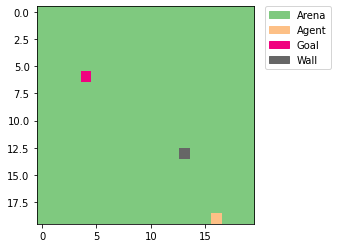

In [5]:
env = gym.make("adversarial-v2")
sum_reward = run_one_episode(env)
print('Sum reward: ', sum_reward)

#visualize(env.state) --> if adversarial_v0

visualize(env.image_space) 

In [6]:
env = gym.make("adversarial-v2")
env.step(0)
env.step(0)

({'image': array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        

In [7]:
history = []

for _ in range(20):
    sum_reward = run_one_episode(env, verbose=False)
    history.append(sum_reward)

avg_sum_reward = sum(history) / len(history)
print("\nbaseline cumulative reward: {:6.2}".format(avg_sum_reward))

#history


baseline cumulative reward:  1e+01


In [8]:
env.image_space.shape

(20, 20)

# Train

Initialize the directory in which to save checkpoints (i.e., serialize a policy to disk) as a subdirectory ./tmp/exa and also the directory in which to write the logs which Ray expects to be at ~/ray_results/ by default:

In [9]:
import os
import shutil

chkpt_root = "tmp/exa"

shutil.rmtree(chkpt_root, ignore_errors=True, onerror=None)
ray_results = "{}/ray_results/".format(os.getenv("HOME"))
shutil.rmtree(ray_results, ignore_errors=True, onerror=None)

We’ll start Ray running in local mode, i.e., not running on a remote cluster:

In [10]:
import ray

ray.init(ignore_reinit_error=True, local_mode=True)

2021-04-21 16:10:30,699	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '128.179.144.248',
 'raylet_ip_address': '128.179.144.248',
 'redis_address': '128.179.144.248:6379',
 'object_store_address': '/tmp/ray/session_2021-04-21_16-10-30_180051_6081/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-04-21_16-10-30_180051_6081/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-04-21_16-10-30_180051_6081',
 'metrics_export_port': 49593,
 'node_id': 'b4a6ea629362e21d87711d9f448dc2834afc1bc41ed7078a28443683'}

Register our environment

In [11]:
from ray.tune.registry import register_env
from gym_example.envs.adversarial_v2 import Adversarial_v2

select_env = "adversarial-v2"
register_env(select_env, lambda config: Adversarial_v2())

Next we’ll configure the environment to use proximal policy optimization (PPO) and create an agent to train using RLlib:

In [12]:
import ray.rllib.agents.ppo as ppo

config = ppo.DEFAULT_CONFIG.copy()

config["log_level"] = "WARN"
agent = ppo.PPOTrainer(config, env=select_env)

2021-04-21 16:10:32,542	INFO trainer.py:616 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
2021-04-21 16:10:32,542	INFO trainer.py:643 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2021-04-21 16:10:32,599	WARNING deprecation.py:34 -- DeprecationWarning: `framestack` has been deprecated. Use `num_framestacks (int)` instead. This will raise an error in the future!
2021-04-21 16:10:33,549	WARNING deprecation.py:34 -- DeprecationWarning: `framestack` has been deprecated. Use `num_framestacks (int)` instead. This will raise an error in the future!
2021-04-21 16:10:34,476	WARNING deprecation.py:34 -- DeprecationWarning: `framestack` has been deprecated. Use `num_framestacks (int)` instead. This will raise an error in the future!
2021-04-21 16:10:37,290	WARNING util.py:47 -- Install gputil for GPU system monitoring.


In [35]:
import ray.rllib.agents.ppo as ppo

config = ppo.DEFAULT_CONFIG.copy()

config["log_level"] = "WARN"

config = ppo.DEFAULT_CONFIG.copy()
config['num_workers'] = 0
config["log_level"] = "WARN"
#config["timesteps_per_iteration"] = 1
config["train_batch_size"] = 1
config["sgd_minibatch_size"] = 1
config["num_sgd_iter"] = 1
config["timesteps_per_iteration"] = 4
config["rollout_fragment_length"] = 1

agent = ppo.PPOTrainer(config, env=select_env)

2021-04-21 16:21:08,778	WARNING deprecation.py:34 -- DeprecationWarning: `framestack` has been deprecated. Use `num_framestacks (int)` instead. This will raise an error in the future!
2021-04-21 16:21:11,259	WARNING util.py:47 -- Install gputil for GPU system monitoring.


For each iteration, we call result = agent.train() to run the episodes, and then call chkpt_file = agent.save(chkpt_root) to save a checkpoint of the latest policy. Then we print metrics that show how well the learning has progressed. The resulting output should look close to the following:

In [38]:
status = "{:2d} reward {:6.2f}/{:6.2f}/{:6.2f} len {:4.2f} saved {}"
n_iter = 6
for n in range(n_iter):
    result = agent.train()
    chkpt_file = agent.save(chkpt_root)
    print(status.format(
            n + 1,
            result["episode_reward_min"],
            result["episode_reward_mean"],
            result["episode_reward_max"],
            result["episode_len_mean"],
            chkpt_file
            ))

 1 reward   8.00/ 11.57/ 20.00 len 4.00 saved tmp/exa/checkpoint_7/checkpoint-7
 2 reward   8.00/ 12.25/ 20.00 len 4.00 saved tmp/exa/checkpoint_8/checkpoint-8
 3 reward   8.00/ 12.22/ 20.00 len 4.00 saved tmp/exa/checkpoint_9/checkpoint-9
 4 reward   8.00/ 12.50/ 20.00 len 4.00 saved tmp/exa/checkpoint_10/checkpoint-10
 5 reward   8.00/ 13.18/ 20.00 len 4.00 saved tmp/exa/checkpoint_11/checkpoint-11
 6 reward   5.00/ 12.50/ 20.00 len 4.00 saved tmp/exa/checkpoint_12/checkpoint-12


In [39]:
result

{'episode_reward_max': 20.0,
 'episode_reward_min': 5.0,
 'episode_reward_mean': 12.5,
 'episode_len_mean': 4.0,
 'episodes_this_iter': 1,
 'policy_reward_min': {},
 'policy_reward_max': {},
 'policy_reward_mean': {},
 'custom_metrics': {},
 'hist_stats': {'episode_reward': [5.0,
   8.0,
   9.0,
   11.0,
   12.0,
   20.0,
   12.0,
   9.0,
   17.0,
   12.0,
   15.0,
   20.0],
  'episode_lengths': [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]},
 'sampler_perf': {'mean_env_wait_ms': 0.6295241681731655,
  'mean_raw_obs_processing_ms': 2.5046268024011504,
  'mean_inference_ms': 6.261897557364377,
  'mean_action_processing_ms': 0.07229448978360566},
 'off_policy_estimator': {},
 'num_healthy_workers': 0,
 'timesteps_total': 48,
 'timers': {'sample_time_ms': 4.365,
  'sample_throughput': 229.117,
  'load_time_ms': 0.644,
  'load_throughput': 1552.813,
  'learn_time_ms': 2.208,
  'learn_throughput': 452.958},
 'info': {'learner': {'default_policy': {'cur_kl_coeff': 1.421085492696024e-15,
    'cur_lr': 

In [ ]:
tensorboard --logdir=$HOME/ray_results

# Apply a trained policy in a rollout

In [ ]:
chkpt_root = "tmp/exa"
chkpt_file = chkpt_root + '/checkpoint_35/checkpoint-35'

#restore the latest saved checkpoint for the policy
agent.restore(chkpt_file)
#create our environment 
env = gym.make(select_env)
#reset its state
state = env.reset()

In [ ]:
# Visualize some of the environments created
sum_reward = 0
n_step = 10
for step in range(n_step):
    action = agent.compute_action(state)
    state, reward, done, info = env.step(action)    
    sum_reward += reward
    #env.render()    
    if done == True:
        print("cumulative reward", sum_reward)
        visualize(env.image_space) 
        state = env.reset()
        sum_reward = 0

# Create environment

In [ ]:
from utils import *
import gym

In [ ]:
from ray.tune.registry import register_env
from gym_example.envs.adversarial_v2 import Adversarial_v2

select_env = "adversarial-v2"
register_env(select_env, lambda config: Adversarial_v2())

In [ ]:
import ray

ray.init(ignore_reinit_error=True, local_mode=True)

import ray.rllib.agents.ppo as ppo

config = ppo.DEFAULT_CONFIG.copy()

config["log_level"] = "WARN"
agent = ppo.PPOTrainer(config, env=select_env)

In [ ]:
config

In [ ]:
chkpt_root = "tmp/exa"
chkpt_file = chkpt_root + '/checkpoint_35/checkpoint-35'

#restore the latest saved checkpoint for the policy
agent.restore(chkpt_file)
#create our environment 
env = gym.make(select_env)
#reset its state
state = env.reset()

sum_reward = 0
n_step = 3
for step in range(n_step):
    action = agent.compute_action(state)
    state, reward, done, info = env.step(action)    
    sum_reward += reward
    #env.render()    
    if done == True:
        print("cumulative reward", sum_reward)
        visualize(env.image_space) 
        state = env.reset()
        sum_reward = 0

In [ ]:
visualize(env.image_space) 

In [ ]:
# padd with zeroes

matrix = np.zeros((40, 40))
# actually you can also use result = np.zeros_like(b) 
# but that also copies the dtype not only the shape

matrix[1:39,1:39] = env.image_space
matrix

In [ ]:
my_config = matrix2arena(matrix)
#my_config.to_proto()

In [ ]:
# visualize evironment just created

try:
    environment = AnimalAIEnvironment(
            file_name='../env/AnimalAI',
            base_port=5007,
            arenas_configurations=my_config,
            play=True,
            worker_id = 5,
        )
except UnityCommunicationException:
    # you'll end up here if you close the environment window directly
    # always try to close it from script
    environment.close()

In [ ]:
if environment:
    environment.close() # takes a few seconds